# Importing Library and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import shap


In [ ]:
rawhistory = pd.read_csv("refreshhistory_raw.csv")
rawhistory.head()

status
Completed    1257
Failed         31
Name: count, dtype: int64


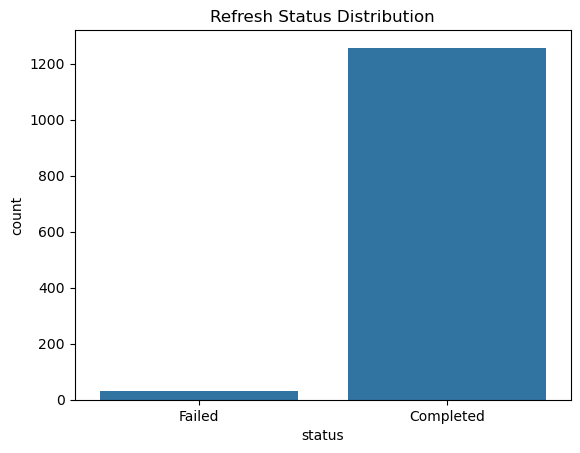

In [3]:
#Target Variable
print(rawhistory['status'].value_counts())

sns.countplot(data=rawhistory, x='status')
plt.title("Refresh Status Distribution")
plt.show()

# Dropping Null Values

In [4]:
print("Dataset info:")
rawhistory.info()

print("\nMissing values per column:")
print(rawhistory.isnull().sum())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   requestId             1288 non-null   object 
 1   id                    1288 non-null   int64  
 2   refreshType           1288 non-null   object 
 3   RefreshStartTime      1282 non-null   object 
 4   RefreshEndTime        1282 non-null   object 
 5   status                1288 non-null   object 
 6   workspaceid           1288 non-null   object 
 7   workspacename         1288 non-null   object 
 8   datasetid             1288 non-null   object 
 9   datasetname           1288 non-null   object 
 10  serviceExceptionJson  31 non-null     object 
 11  AttemptID             1288 non-null   int64  
 12  Type                  1288 non-null   object 
 13  NextStartTime         1288 non-null   object 
 14  NextEndTime           1288 non-null   object 
 15  ErrorCo

In [5]:
rawhistory = rawhistory.dropna(subset=['RefreshStartTime', 'RefreshEndTime', 'RefreshDuration_Min'])


In [6]:
print("Dataset info:")
rawhistory.info()

print("\nMissing values per column:")
print(rawhistory.isnull().sum())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1276 entries, 0 to 1287
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   requestId             1276 non-null   object 
 1   id                    1276 non-null   int64  
 2   refreshType           1276 non-null   object 
 3   RefreshStartTime      1276 non-null   object 
 4   RefreshEndTime        1276 non-null   object 
 5   status                1276 non-null   object 
 6   workspaceid           1276 non-null   object 
 7   workspacename         1276 non-null   object 
 8   datasetid             1276 non-null   object 
 9   datasetname           1276 non-null   object 
 10  serviceExceptionJson  31 non-null     object 
 11  AttemptID             1276 non-null   int64  
 12  Type                  1276 non-null   object 
 13  NextStartTime         1276 non-null   object 
 14  NextEndTime           1276 non-null   object 
 15  ErrorCode   

status
Completed    1245
Failed         31
Name: count, dtype: int64


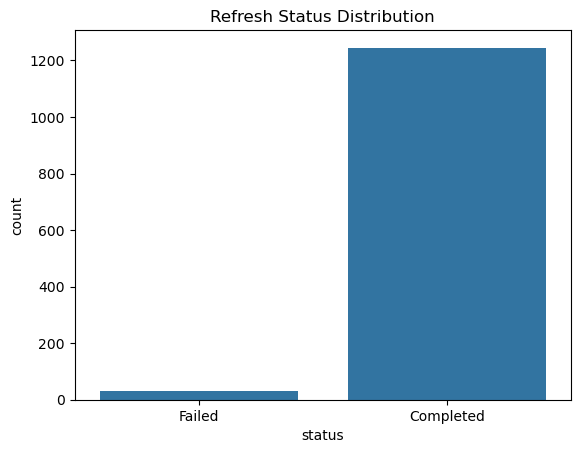

In [7]:
#Target Variable
print(rawhistory['status'].value_counts())

sns.countplot(data=rawhistory, x='status')
plt.title("Refresh Status Distribution")
plt.show()

# Distrubution on  RefreshType and Distribution Type

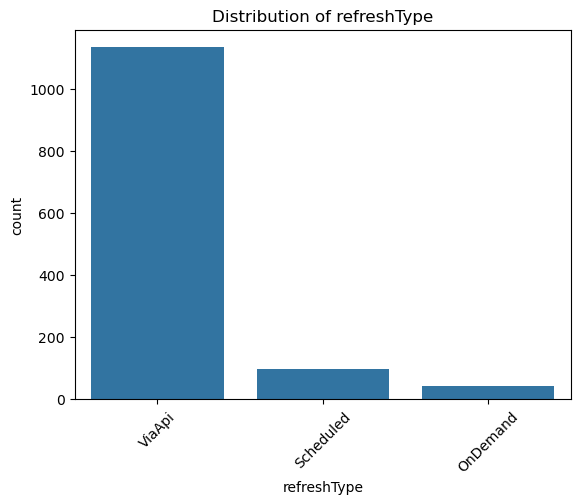

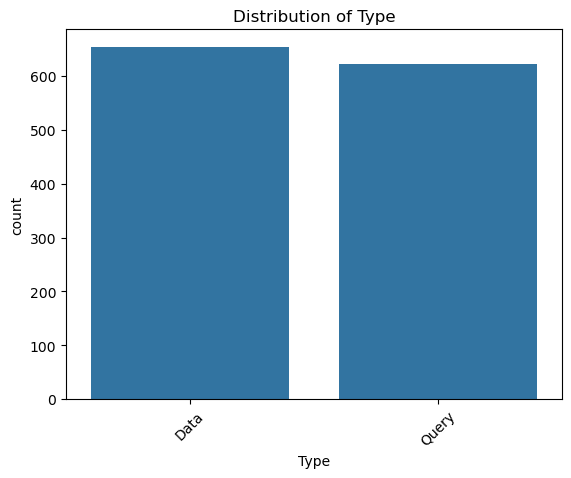

In [8]:
for col in ['refreshType', 'Type']:
    if col in rawhistory.columns:
        sns.countplot(data=rawhistory, x=col, order=rawhistory[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()


# Status based off Refresh Types

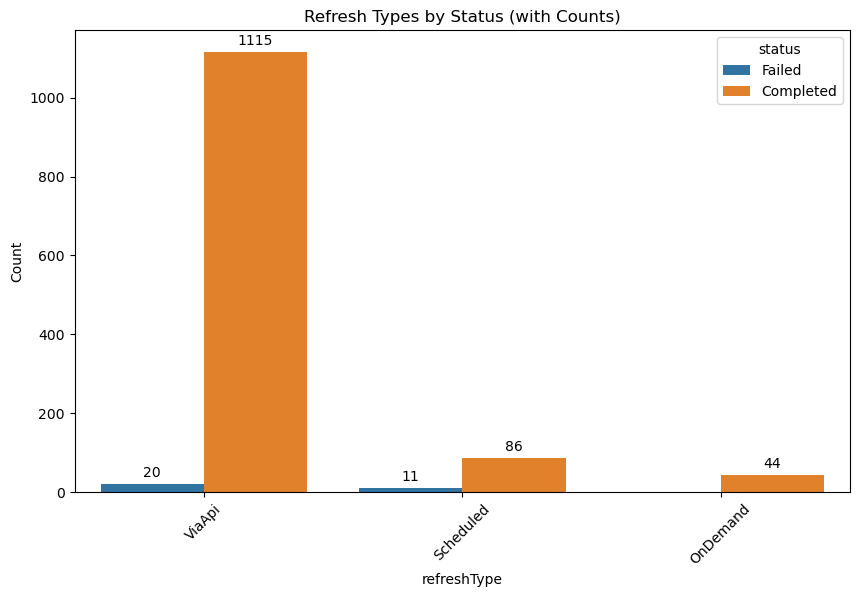

In [9]:


plt.figure(figsize=(10,6))
ax = sns.countplot(data=rawhistory, x='refreshType', hue='status')

# Add count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.title("Refresh Types by Status (with Counts)")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


# Failure Rates

In [10]:
failure_rate = (
    rawhistory.groupby('refreshType')['status']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .sort_values(by='Failed', ascending=False)
)
print(failure_rate)


status       Completed    Failed
refreshType                     
Scheduled     0.886598  0.113402
ViaApi        0.982379  0.017621
OnDemand      1.000000  0.000000


# Dsitrubution Of Duration Based on Status

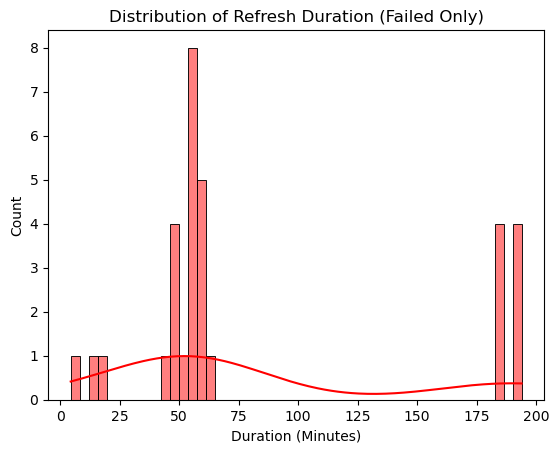

In [11]:
sns.histplot(
    data=rawhistory[rawhistory['status'] == 'Failed'],
    x='RefreshDuration_Min',
    bins=50,
    kde=True,
    color='red'
)
plt.title("Distribution of Refresh Duration (Failed Only)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Count")
plt.show()


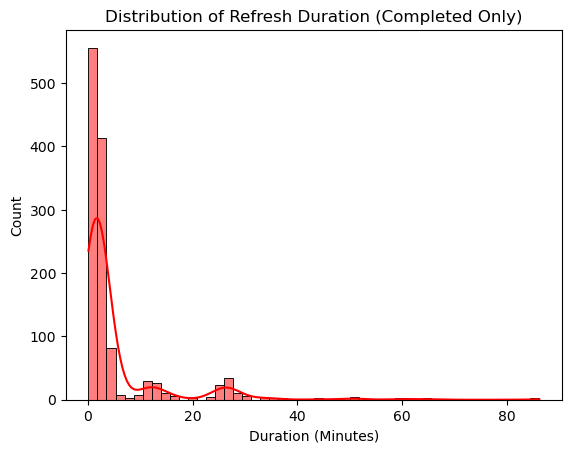

In [12]:
sns.histplot(
    data=rawhistory[rawhistory['status'] == 'Completed'],
    x='RefreshDuration_Min',
    bins=50,
    kde=True,
    color='red'
)
plt.title("Distribution of Refresh Duration (Completed Only)")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Count")
plt.show()


# Failure by Datasets

In [13]:
# Datasets with highest failure *rate* (not just raw count)
failure_rates = (
    rawhistory.groupby('datasetname')['status']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .sort_values(by='Failed', ascending=False)
)
print(failure_rates.head(10))


status                                              Completed    Failed
datasetname                                                            
Utilization Report                                   0.666667  0.333333
Refresh Demo Solution - OptimizedV3-RefreshDisa...   0.700000  0.300000
Inventory Aging Analysis                             0.974359  0.025641
ISR Dashboard                                        0.974359  0.025641
Inventory Overview                                   0.974359  0.025641
W2PE Utilization Report                              1.000000  0.000000
Utilization Reclass Report                           1.000000  0.000000
Utilization Projection                               1.000000  0.000000
Warehouse Ops Dashboard                              1.000000  0.000000
Resource Task Assignments                            1.000000  0.000000


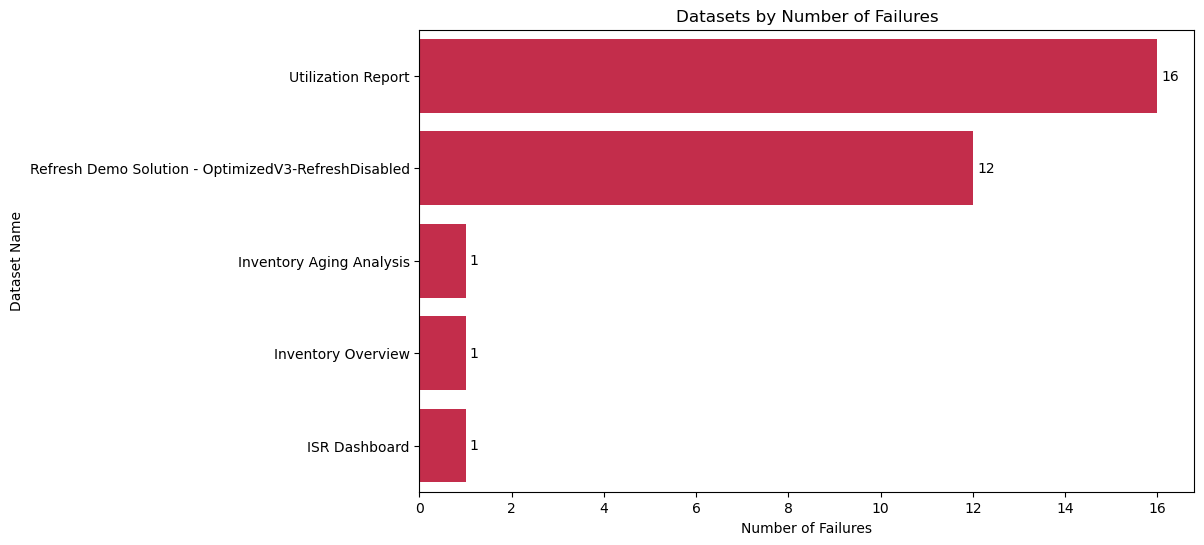

In [14]:

# Filter only failed refreshes
failed_only = rawhistory[rawhistory['status'] == 'Failed']

# Count failures per dataset
top_failed_datasets = failed_only['datasetname'].value_counts().head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(y=top_failed_datasets.index, x=top_failed_datasets.values, color='crimson')
plt.title("Datasets by Number of Failures")
plt.xlabel("Number of Failures")
plt.ylabel("Dataset Name")

# Add count labels on the bars
ax.bar_label(ax.containers[0], padding=3)

plt.show()


# Workspace based on Status

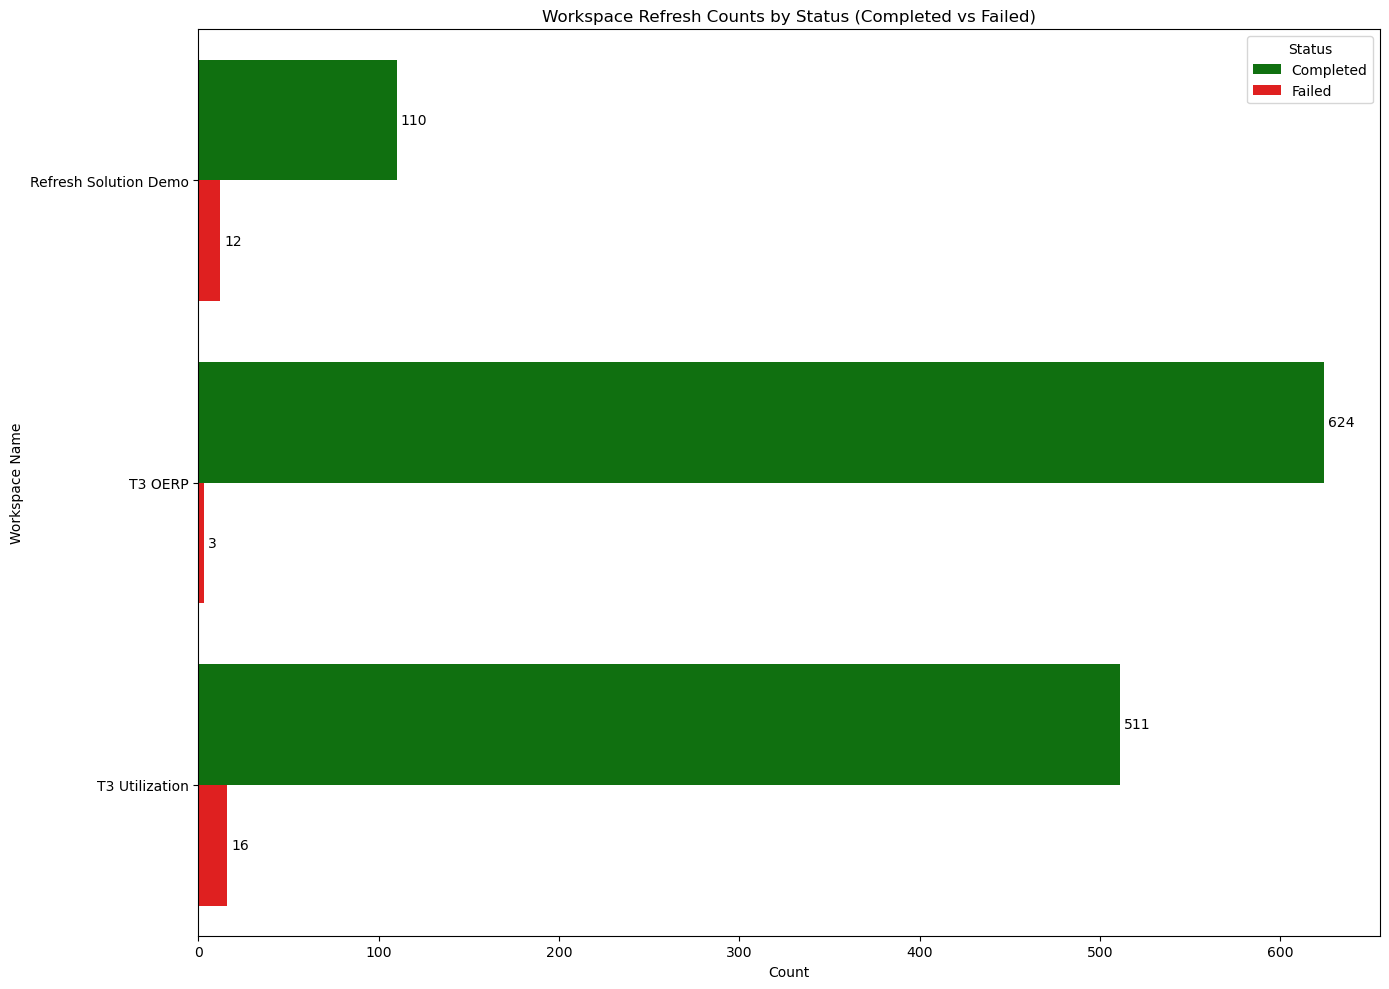

In [15]:

# Count status per workspace
workspace_status_counts = rawhistory.groupby(['workspacename', 'status']).size().reset_index(name='count')

plt.figure(figsize=(14,10))
ax = sns.barplot(data=workspace_status_counts, x='count', y='workspacename', hue='status', palette=['green', 'red'])

plt.title("Workspace Refresh Counts by Status (Completed vs Failed)")
plt.xlabel("Count")
plt.ylabel("Workspace Name")
plt.legend(title='Status')
plt.tight_layout()

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

plt.show()


In [16]:
rawhistory.to_csv('clean_rawhistory.csv', index=False)

# New Raw Hisotry 

In [17]:
raw1 = pd.read_csv("refreshhistory_raw(1).csv")

In [ ]:
raw1

status
Completed    1110
Failed         81
Name: count, dtype: int64


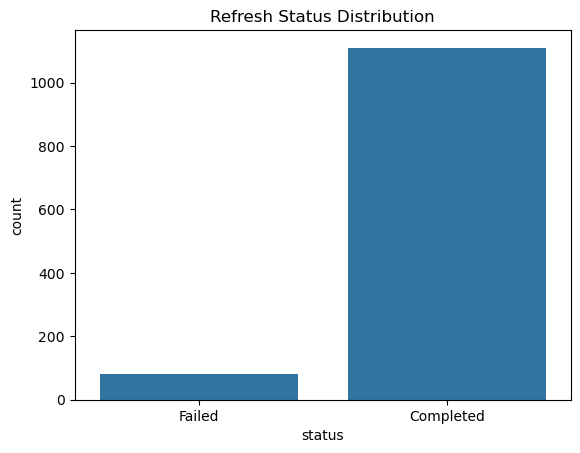

In [19]:
#Target Variable
print(raw1['status'].value_counts())

sns.countplot(data=raw1, x='status')
plt.title("Refresh Status Distribution")
plt.show()

In [24]:
raw1.to_csv('raw1.csv', index=False)